In [ ]:
!pip install gensim==3.*
!pip install --index-url http://pypi.artifacts.furycloud.io/ \
    --trusted-host pypi.artifacts.furycloud.io \
    replib.descriptors.metaprod2vec==1.1.0


In [120]:
import json
import unicodedata
import pandas as pd
import re
import string
import zipfile

from datetime import datetime
from pandas import json_normalize

####### Predict Title

from replib.descriptors.metaprod2vec import MetaProd2Vec

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier


## Pre-processing

In [133]:
# You can safely assume that `build_dataset` is correctly implemented
def build_dataset():
    data = [json.loads(x) for x in open("MLA_100k_checked_v3.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test


if __name__ == "__main__":
    print("Loading dataset...")
    # Train and test data following sklearn naming conventions
    # X_train (X_test too) is a list of dicts with information about each item.
    # y_train (y_test too) contains the labels to be predicted (new or used).
    # The label of X_train[i] is y_train[i].
    # The label of X_test[i] is y_test[i].
    X_train, y_train, X_test, y_test = build_dataset()

Loading dataset...


In [134]:
###########################
######
###### Pre-Processing Step
#####
###########################

def step01_preproc(df):
    
    df = pd.json_normalize(df, sep="_").rename(columns={'id': 'key'})

    #### Pivots with aggregations

    # non_mercado_pago_payment_methods ######################################
    df_normalized = json_normalize(df.to_dict('records'), record_path='non_mercado_pago_payment_methods', meta=["key"])
    # Dummies with id  
    pivot_df = pd.pivot_table(df_normalized, index='key',\
                              columns=['id'], values='description', aggfunc=len).fillna(0).add_prefix('trat_pay_')
    df = pd.merge(df, pivot_df, on='key', how='outer')
    # Counting type
    pivot_df = pd.pivot_table(df_normalized, index='key',\
                              columns=['type'], values='description', aggfunc=len).fillna(0).fillna(0).add_prefix('trat_pay_')
    df = pd.merge(df, pivot_df, on='key', how='outer')

    # deal_ids ######################################
    df['trat_deal_ids'] = df['deal_ids'].apply(lambda x: bin(0 if x == 'Missing' else 1)[2:])

    # variations ######################################
    df_normalized = json_normalize(df.to_dict('records'), record_path='variations', meta=["key"])
    df_normalized2 = json_normalize(df_normalized.to_dict('records'), record_path='attribute_combinations', meta=["key"])
    # seller_custom_field
    df_normalized['seller_custom_field_flag'] = df_normalized['seller_custom_field'].apply(lambda x: bin(0 if x == None else 1)[2:])
    # num_pictures
    df_normalized['num_pictures_ids'] = df_normalized['picture_ids'].apply(lambda x: len(x))
    # features to keep first level
    pivot_df = pd.pivot_table(df_normalized, index=["key"],\
                              values=["available_quantity", "sold_quantity", "num_pictures_ids", "seller_custom_field_flag"],\
                              aggfunc="max").fillna(0).add_prefix('trat_var_')
    df = pd.merge(df, pivot_df, on='key', how='outer')

    # features to keep second level
    pivot_df = pd.pivot_table(df_normalized2, index='key',\
                              columns=['value_id'], aggfunc=len).fillna(0).add_prefix('trat_var')
    pivot_df.columns = ["_".join(col).strip() for col in pivot_df.columns.values]
    df = pd.merge(df, pivot_df, on='key', how='outer')

    # seller historical data ######################################
    pivot_df = pd.pivot_table(df, index=["seller_id"],values=["key"],\
                              aggfunc=pd.Series.nunique).fillna(0).add_prefix('trat_sel_')

    # attributes ######################################
    df_normalized = json_normalize(df.to_dict('records'), record_path='attributes', meta=["key"])
    pivot_df = pd.pivot_table(df_normalized, index='key',\
                              columns=["attribute_group_id"],values='attribute_group_name',aggfunc=pd.Series.nunique).fillna(0).add_prefix('trat_attr_')
    df = pd.merge(df, pivot_df, on='key', how='outer')

    
    #### Dummies

    # listing_type_id ######################################
    dummies = pd.get_dummies(df["listing_type_id"], prefix="trat_lis")
    df = pd.concat([df, dummies], axis=1)

    # buying_mode ######################################
    dummies = pd.get_dummies(df["buying_mode"], prefix="trat_buy")
    df = pd.concat([df, dummies], axis=1)

    # accepts_mercadopago ######################################
    dummies = pd.get_dummies(df["accepts_mercadopago"], prefix="trat_mp")
    df = pd.concat([df, dummies], axis=1)

    # currency_id ######################################
    dummies = pd.get_dummies(df["currency_id"], prefix="trat_cur")
    df = pd.concat([df, dummies], axis=1)

    # automatic_relist ######################################
    dummies = pd.get_dummies(df["automatic_relist"], prefix="trat_rel")
    df = pd.concat([df, dummies], axis=1)

    # status ######################################
    dummies = pd.get_dummies(df["status"], prefix="trat_status")
    df = pd.concat([df, dummies], axis=1)

    # seller_address_state_id ######################################
    dummies = pd.get_dummies(df["seller_address_state_id"], prefix="trat_sel_adr")
    df = pd.concat([df, dummies], axis=1)

    # shipping_local_pick_up ######################################
    dummies = pd.get_dummies(df["shipping_local_pick_up"], prefix="trat_ship_pick")
    df = pd.concat([df, dummies], axis=1)

    # shipping_free_shipping ######################################
    dummies = pd.get_dummies(df["shipping_free_shipping"], prefix="trat_ship_free")
    df = pd.concat([df, dummies], axis=1)

    # shipping_mode ######################################
    dummies = pd.get_dummies(df["shipping_mode"], prefix="trat_ship_mode")
    df = pd.concat([df, dummies], axis=1)

    # permalink ######################################
    regex = r'\/\/(.*?)\.'
    df['permalink_aux'] = df['permalink'].apply(lambda x: re.search(regex, x).group(1))
    dummies = pd.get_dummies(df["permalink_aux"], prefix="trat_perm")
    df = pd.concat([df, dummies], axis=1)


    # last_updated
    df['trat_anomes'] = df['last_updated'].apply(lambda x: "{}{:02d}".format(*datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ").timetuple()[:2]))
    # original_price
    df['trat_original_price'] = df['original_price'].fillna(0).apply(lambda x: 1 if x > 0 else 0)
    # date_created
    df['trat_anomes_date_created'] = df['date_created'].apply(lambda x: "{}{:02d}".format(*datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ").timetuple()[:2]))
    df['trat_diferenca_data'] = df['trat_anomes'].astype(int) - df['trat_anomes_date_created'].astype(int)
    # date_created
    df['trat_sell_city_temid'] = df['seller_address_city_id'].apply(lambda x: bin(1 if x == '' else 0)[2:])
    df['trat_diferenca_time'] = (((df['stop_time'].astype(int) - df['start_time'].astype(int))/ 1000 / 60 / 60 / 24)).astype(int)
    # video_id
    df['trat_video_id'] = df['video_id'].apply(lambda x: bin(0 if x == None else 1)[2:])
    # tags
    df['trat_good_present'] = df['tags'].apply(lambda x: 1 if 'good_quality_thumbnail' in x else 0)

    # continuo
    # trunc in perc 99 and divide by std after trunc
    df['trat_price_c'] = (df['price'].apply(lambda x: 13000 if x > 13000 else x)) / 2725.186005
    df['trat_initial_quantity_c'] = (df['initial_quantity'].apply(lambda x: 990 if x > 990 else x)) / 111.134761
    df['trat_sold_quantity_c'] = (df['sold_quantity'].apply(lambda x: 41 if x > 41 else x)) / 5.201335
    df['trat_available_quantity_c'] = (df['available_quantity'].apply(lambda x: 986 if x > 986 else x)) / 110.436919
    

    #### Bivariate by category -- trying avoid overfitting

    # Worst 90% to 100% used aprox.
    codigos = ['MLA85103', 'MLA12205', 'MLA34370', 'MLA15328', 'MLA12204', 'MLA47329',
               'MLA31771', 'MLA37759', 'MLA41112', 'MLA2022', 'MLA29389', 'MLA2069',
               'MLA10127', 'MLA2038', 'MLA2024', 'MLA44020', 'MLA40547', 'MLA41056',
               'MLA3476', 'MLA10937', 'MLA1383', 'MLA41278', 'MLA1207', 'MLA41269',
               'MLA3392', 'MLA15210', 'MLA48855']

    df['trat_category_id_w1'] = df['category_id'].str.contains('|'.join(codigos)).astype(int)

    # Worst 80% to 90% used aprox.
    codigos = ['MLA5500', 'MLA15218', 'MLA35923', 'MLA41260', 'MLA5496', 'MLA1963',
               'MLA15201', 'MLA41097', 'MLA2032', 'MLA41173', 'MLA41287', 'MLA41064',
               'MLA7111', 'MLA3032', 'MLA3991', 'MLA40507', 'MLA41174', 'MLA41083',
               'MLA41175', 'MLA41146', 'MLA7373', 'MLA41057', 'MLA40500', 'MLA2458',
               'MLA41176', 'MLA1832', 'MLA2070', 'MLA41065', 'MLA9259', 'MLA5492', 'MLA40497']

    df['trat_category_id_w2'] = df['category_id'].str.contains('|'.join(codigos)).astype(int)

    # Worst 70% to 80% used aprox.
    codigos = ['MLA5599', 'MLA15191', 'MLA15157', 'MLA4785', 'MLA7243', 'MLA3031', 
               'MLA82335', 'MLA31797', 'MLA41192', 'MLA2044', 'MLA11456', 'MLA2040', 
               'MLA2039', 'MLA41185', 'MLA6087', 'MLA2470', 'MLA15163', 'MLA41149']

    df['trat_category_id_w3'] = df['category_id'].str.contains('|'.join(codigos)).astype(int)


    # Worst 50% to 60% used aprox.
    codigos = ['MLA6009', 'MLA41259', 'MLA1495', 'MLA7251', 'MLA89995', 'MLA370638', 
               'MLA15171', 'MLA370630', 'MLA40526', 'MLA15172', 'MLA1468', 'MLA1474', 
               'MLA15197', 'MLA1458', 'MLA15226', 'MLA1227']

    df['trat_category_id_w4'] = df['category_id'].str.contains('|'.join(codigos)).astype(int)

    # Best 0% to 10% used aprox.
    codigos = ['MLA60611', 'MLA352293', 'MLA373016', 'MLA60671', 'MLA352345', 'MLA373122',
               'MLA61144', 'MLA45558', 'MLA375228', 'MLA373009', 'MLA60668', 'MLA1429',
               'MLA60614', 'MLA374976', 'MLA7859', 'MLA85986', 'MLA60598', 'MLA375067',
               'MLA26536', 'MLA3936', 'MLA373299', 'MLA48895', 'MLA73721', 'MLA3931', 
               'MLA34199', 'MLA117185', 'MLA10076', 'MLA48904', 'MLA85960', 'MLA5375', 
               'MLA34325', 'MLA22281', 'MLA352333', 'MLA6651', 'MLA86025', 'MLA10216',
               'MLA1914', 'MLA372114', 'MLA1590', 'MLA70503', 'MLA119287', 'MLA373335',
               'MLA4747', 'MLA86029', 'MLA70504']

    df['trat_category_id_b1'] = df['category_id'].str.contains('|'.join(codigos)).astype(int)


    # Best 10% to 30% used aprox.
    codigos = ['MLA3698', 'MLA6095', 'MLA1642', 'MLA4789', 'MLA12812', 'MLA30216', 
               'MLA34294', 'MLA1162', 'MLA3529', 'MLA1912', 'MLA1503', 'MLA21086', 
               'MLA1901', 'MLA1643', 'MLA1607', 'MLA6177', 'MLA2879', 'MLA4734', 
               'MLA9992', 'MLA3121', 'MLA2980']

    df['trat_category_id_b2'] = df['category_id'].str.contains('|'.join(codigos)).astype(int)
    
    
    return df

In [135]:
df_train = step01_preproc(X_train)
df_test  = step01_preproc(X_test)

In [136]:
###########################
######
###### Warranty - WordCount (Embeddings)
#####
###########################


def step02_waranty_transform(df):

    # Positives due warranty time specification
    palavras = ['1 ano', '2 anos', '5 anos', '3 meses', '4 meses' , '12 meses']
    regex = "|".join([rf"\b{palavra}\b" for palavra in palavras])
    df["trat_warranty_time"]= df["warranty"].apply(lambda x: '' if x is None else unicodedata.normalize('NFKD', x) \
                                .encode('ASCII', 'ignore').decode('utf-8')) \
                                .str.translate(str.maketrans('', '', string.punctuation)) \
                                .str.contains(regex, regex=True).apply(lambda x: bin(1 if x == True else 0)[2:])

    # Positives due Origin
    palavras = ["fabrica","fabricacion","fabricante","directo","directamente","novo","oficial","nuevo"]
    regex = "|".join([rf"\b{palavra}\b" for palavra in palavras])
    df["trat_warranty_fabric"]= df["warranty"].apply(lambda x: '' if x is None else unicodedata.normalize('NFKD', x) \
                                .encode('ASCII', 'ignore').decode('utf-8')) \
                                .str.translate(str.maketrans('', '', string.punctuation)) \
                                .str.contains(regex, regex=True).apply(lambda x: bin(1 if x == True else 0)[2:])
    
    # Negative due reputation needs check
    palavras = ["reputacion" ,"calificacion","calificaciones","sin garantia","revisan", "revisados", "buen", "buenas", "corresponden","perfecto","articulo","descripcion","revisa","completo"]
    regex = "|".join([rf"\b{palavra}\b" for palavra in palavras])
    df["trat_warranty_reputation"]= df["warranty"].apply(lambda x: '' if x is None else unicodedata.normalize('NFKD', x) \
                                .encode('ASCII', 'ignore').decode('utf-8')) \
                                .str.translate(str.maketrans('', '', string.punctuation)) \
                                .str.contains(regex, regex=True).apply(lambda x: bin(1 if x == True else 0)[2:])
    
    # Negative due image needs
    palavras = ["foto","fotos","imagem","imagenes"]
    regex = "|".join([rf"\b{palavra}\b" for palavra in palavras])
    df["trat_warranty_image"]= df["warranty"].apply(lambda x: '' if x is None else unicodedata.normalize('NFKD', x) \
                                .encode('ASCII', 'ignore').decode('utf-8')) \
                                .str.translate(str.maketrans('', '', string.punctuation)) \
                                .str.contains(regex, regex=True).apply(lambda x: bin(1 if x == True else 0)[2:])
    
    return df

In [137]:
df_train = step02_waranty_transform(df_train)
df_test  = step02_waranty_transform(df_test)

In [138]:
###########################
######
###### Replib for title field - train
#####
###########################

def step03_replib_train(df_train):
    
    
    ## Training Step       
    # RF
    params = {
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'max_features': 'sqrt',
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = make_pipeline(
        MetaProd2Vec(pre_fitted_version="MLA_feb21_dim100")
        ,RandomForestClassifier(**params)
    )
    
    targets = df_train['condition']
    titles = df_train["title"].fillna('XXXX').tolist()
    items = [{"title": title} for title in titles]
    
    return model.fit(items, targets)   

In [139]:
model_replib = step03_replib_train(df_train)

In [140]:
###########################
######
###### Replib for title field - predict
#####
###########################

def step04_replib_predict(df_train,df_test,model_replib):
    
    titles_train = df_train["title"].fillna('XXXX').tolist()
    items_train = [{"title": title} for title in titles_train]
    df_train['trat_rep_title'] = model_replib.predict_proba(items_train)[:, 0]
    
    titles_test = df_test["title"].fillna('XXXX').tolist()
    items_test = [{"title": title} for title in titles_test]
    df_test['trat_rep_title'] = model_replib.predict_proba(items_test)[:, 0]
    
    return df_train, df_test

In [141]:
df_train, df_test = step04_replib_predict(df_train,df_test,model_replib)

In [142]:
###########################
######
###### Clean unused columns 
#####
###########################

def step05_clean_dataframes(df_train,df_test):
    
    df_train.set_index('key', inplace=True)
    df_test.set_index('key', inplace=True)
    
    df_train = df_train.filter(regex='^(condition|trat_)').fillna(-1)
    df_test = df_test.filter(regex='^(condition|trat_)').fillna(-1)
    
    return df_train, df_test

In [143]:
df_train, df_test = step05_clean_dataframes(df_train,df_test)

In [84]:
y_true = pd.Series(y_test).apply(lambda x: 1 if x == 'new' else 0)
y_scores = df_test['trat_rep_title']

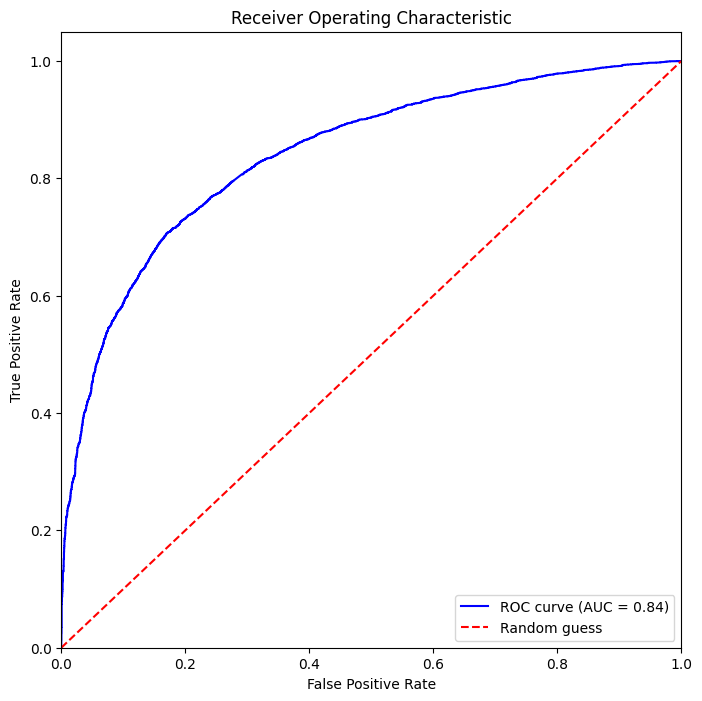

In [85]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Suponha que y_true e y_scores já foram definidos como vetores de valores
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calcula a AUC da curva ROC
roc_auc = roc_auc_score(y_true, y_scores)

# Plota a curva ROC
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [88]:
print(roc_auc == 0.8413205767435238)

True


In [91]:
###########################
######
###### Replib for title field - train
#####
###########################

def step06_model_train(df_train):
    
    
    ## Training Step       
    # RF
    params = {
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'max_features': 'sqrt',
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = make_pipeline(
        RandomForestClassifier(**params)
    )
    
    targets = df_train['condition']
    X = df_train.drop(columns=['condition'])

    
    return model.fit(X, targets)   

In [92]:
model_final = step06_model_train(df_train)

In [93]:
df_train['test_final'] = model_final.predict_proba(df_train.drop(columns=['condition']))[:, 0]

In [95]:
y_true = (df_train['condition'].apply(lambda x: 1 if x == 'new' else 0))
y_scores = df_train['test_final']

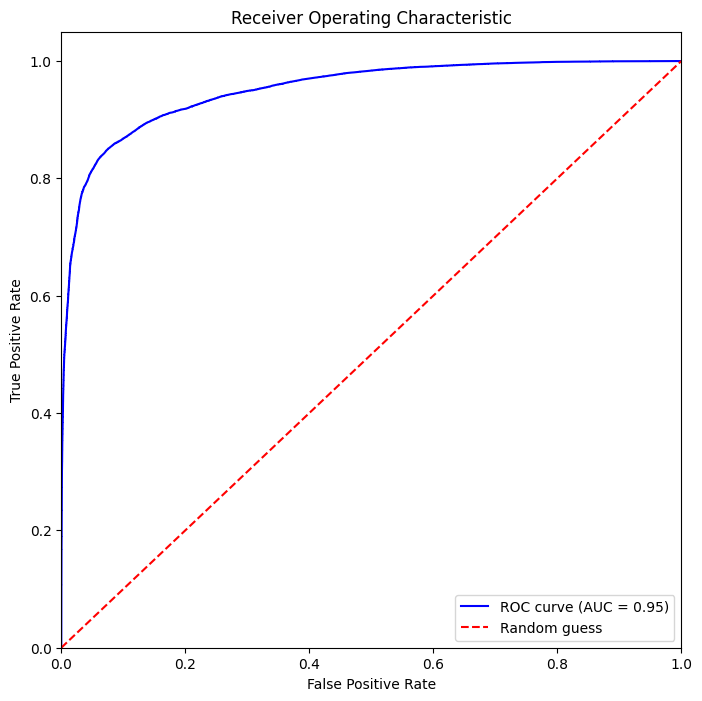

In [96]:
# Suponha que y_true e y_scores já foram definidos como vetores de valores
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calcula a AUC da curva ROC
roc_auc = roc_auc_score(y_true, y_scores)

# Plota a curva ROC
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [110]:
# obter colunas presentes em A e não presentes em B
train_util = df_train.drop(columns=['condition', 'test_final'])

new_cols = set(train_util.columns) - set(df_test.columns)

# adicionar colunas faltantes em B e preencher com -1
for col in new_cols:
    df_test[col] = -1
    
# remover colunas de B que não estão presentes em A
for col in df_test.columns:
    if col not in train_util.columns:
        df_test.drop(columns=[col], inplace=True)
    
# reordenar colunas de B para ficar igual a A
df_test = df_test[train_util.columns].copy()




In [111]:
df_test['test_final'] = model_final.predict_proba(df_test)[:, 0]

In [112]:
y_true = pd.Series(y_test).apply(lambda x: 1 if x == 'new' else 0)
y_scores = df_test['test_final']

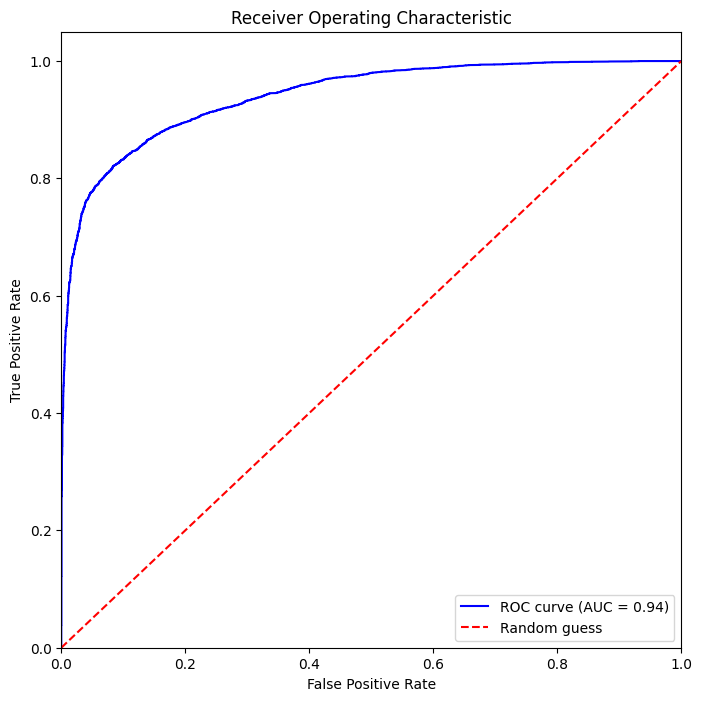

In [113]:
# Suponha que y_true e y_scores já foram definidos como vetores de valores
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calcula a AUC da curva ROC
roc_auc = roc_auc_score(y_true, y_scores)

# Plota a curva ROC
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [146]:
from mlflow import *
from pycaret.classification import *

In [147]:
clf2 = setup(df_train, target = 'condition', session_id=123,numeric_imputation=None , log_experiment=True, experiment_name='test2')

,Description,Value
0,Session id,123
1,Target,condition
2,Target type,Binary
3,Target mapping,"new: 0, used: 1"
4,Original data shape,"(90000, 626)"
5,Transformed data shape,"(90000, 728)"
6,Transformed train set shape,"(62999, 728)"
7,Transformed test set shape,"(27001, 728)"
8,Ordinal features,6
9,Numeric features,615


2023/04/07 17:22:27 INFO mlflow.tracking.fluent: Experiment with name 'test2' does not exist. Creating a new experiment.


In [148]:
best = automl(optimize = 'Accuracy')
best

ValueError: Estimator None does not have the required fit() method.